## This notebook attempts to train and validate a DCTR model paramterized by the top mass

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras
import keras.backend as K

# standard numerical library imports
import numpy as np
import scipy as sp

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# Check versions
print(keras.__version__) #2.2.4

2.2.4


# Load Data

## Utilities

In [4]:
# normalize pT and center (y, phi)
# def normalize(x):
#     mask = x[:,0] > 0
#     yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
#     x[mask,1:3] -= yphi_avg
#     x[mask,0] /= x[:,0].sum()
    
def normalize(x):
    # pT values /100
    x[:,0] /= 100.
    # jet mass values /10
    x[:,3] /= 10.
    # top mass /1000
    x[:,5] /= 1000.
    pass

In [5]:
def preprocess_data(X):
    for x in X: 
        normalize(x)
        
    mTs = X[:,0,5:]
    X = np.reshape(X[:,:,:5], (len(X), 30))
    X = np.concatenate((X, mTs), axis = 1) 
    
    # Remap PIDs to unique values in range [0,1]
    # remap_pids(X, pid_i=4)
    return X

## Process Data

In [6]:
# Path to downloaded data from Zenodo
data_dir = '/data1/users/asuresh/DCTRFitting/'

In [7]:
train_dataset_0_x4 = np.load(data_dir + 'part_172_5_6j_x4.npy')
train_dataset_1_x4 = np.load(data_dir + 'part_varmass_6j_x4.npy')

In [8]:
X0 = train_dataset_0_x4
# shorten X1 to same length as X0   
# s.t. network sees an equal number 
# of examples from X0 and X1        

X1 = train_dataset_1_x4[:len(X0)]

print(np.shape(X0))
print(np.shape(X1))
print(len(X1)/(len(X0)+len(X1))) # X1 percentage of training data 

(266007, 6, 6)
(266007, 6, 6)
0.5


In [9]:
# Zip uniformally sampled top mass in part_varmass_6j
# with part_172_5_6j


# for i in range(len(X1)):
#     for j in range(6):
#         X0[i, j, 4] = X1[i, j, 4]

# X0 already zipped with mT uniformally sampled

In [10]:
Y0 = np.zeros_like(X0[:,0,0])
Y1 = np.ones_like(X1[:,0,0])

In [11]:
X = np.concatenate((X0, X1), axis = 0)
X = preprocess_data(X)

Y = np.concatenate((Y0, Y1), axis = 0)
Y = to_categorical(Y, num_classes=2)

In [12]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.2, shuffle=True)

In [13]:
print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

(425612, 31)
(425612, 2)
(106402, 31)
(106402, 2)


# Build Model

In [14]:
# Build Model
inputs = Input((31, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr = Model(inputs=inputs, outputs=outputs)
dctr.compile(loss='categorical_crossentropy',
                   optimizer='Adam',
                   metrics=['accuracy'])

# Train model

In [15]:
save_label = 'TOP_DCTR'

# checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', 
#                                                 monitor='val_loss', 
#                                                 verbose=2, 
#                                                 save_best_only=True, 
#                                                 mode='min')

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0, 
                                              patience=20, 
                                              verbose=1, 
                                              restore_best_weights=True)

callbacks = [EarlyStopping] # [checkpoint, EarlyStopping]



In [16]:
# n_fail1 = 0
# n_fail2 = 0
# n_succ = 0
# iterations = 100
# for i in range(iterations):
#     print("Iteration: ", i)
    
#     K.clear_session()
#     dctr = PFN(input_dim=6, 
#            Phi_sizes=Phi_sizes, F_sizes=F_sizes,
#            summary=False)
#     lr = 1e-4 #smaller learning rate yields better precision
#     optimizer = keras.optimizers.Adam(lr=lr)
#     dctr.model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
#     history = dctr.fit(X_train, Y_train,
#                         epochs = 1,
#                         batch_size = 1000,
#                         validation_data = (X_val, Y_val),
#                         verbose = 1)
    
#     if history.history['val_loss'][0] > 10: # Fail case 1
#         n_fail1 += 1
#     elif history.history['val_loss'][0] > 2: # Fail case 2
#         n_fail2 += 1
#     else: # success
#         n_succ += 1
#         # serialize weights to HDF5
#         dctr_weights = dctr.get_weights()
#         print("Success")
            
# n_fail = n_fail1 + n_fail2

In [17]:
# n_fail = n_fail1 + n_fail2

# print("Number of initializations failed: ", n_fail, "/", iterations)
# print("Percentage of initializations failed:", (100*n_fail/iterations), "%")

# print("Number of initializations succeeded: ", n_succ, "/", iterations)
# print("Percentage of initializations succeeded:", (100*n_succ/iterations), "%")

Finish training

In [18]:
try:
    history = dctr.fit(X_train, Y_train,
                    epochs = 100,
                    batch_size = 1000,
                    validation_data = (X_val, Y_val),
                    verbose = 1, 
                    callbacks = callbacks)
except:
    print("Model had 0 successful initializations, will not finish training")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 425612 samples, validate on 106402 samples
Epoch 1/100





425612/425612 [==============================] - 4s 9us/step - loss: 0.6940 - acc: 0.5016 - val_loss: 0.6933 - val_acc: 0.5030
Epoch 2/100
425612/425612 [==============================] - 2s 5us/step - loss: 0.6931 - acc: 0.5056 - val_loss: 0.6934 - val_acc: 0.5009
Epoch 3/100
425612/425612 [==============================] - 2s 5us/step - loss: 0.6929 - acc: 0.5088 - val_loss: 0.6933 - val_acc: 0.5026
Epoch 4/100
425612/425612 [==============================] - 2s 5us/step - loss: 0.6928 - acc: 0.5101 - val_loss: 0.6934 - val_acc: 0.5018
Epoch 5/100
425612/425612 [==============================] - 2s 5us/step - loss: 0.6927 - acc: 0.5120 - val_loss: 0.6933 - val_acc: 0.5040
Epoch 6/100
425612/425612 [==============================] - 2s 5us/step - loss: 0.6925 - acc: 0.5140 - val_loss: 0.6935 - val_acc: 0.5028
Epoch 7/100


# Plot History

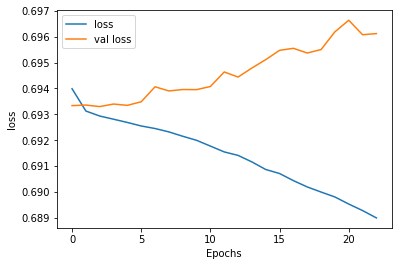

In [19]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

## Load Datasets

In [20]:
test_dataset_0 = np.load(data_dir+'part_172_5_6j.npy')
test_dataset_1 = np.load(data_dir+'part_175_0_6j.npy')

In [21]:
# Define labels for legends
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'

def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

## Get predictions

In [22]:
# Load test datasets
X0_test = test_dataset_0[:,:,:5]
X1_test = test_dataset_1[:,:,:5]



In [23]:
# Define labels for legends
label_0 = r'$m_T=172.5$'

label_1 = r'$m_T=175.0$'

def make_legend():
    ax = plt.gca()
    leg = ax.legend(frameon=False)
    leg._legend_box.align = "left"
    plt.tight_layout()

### Define reweighting function

We must calculate two liklihood ratios during reweighting: the first because the training datasets were different sizes, and the second because the validation datasets are different sizes.

In [24]:
# Get predicted probabilities
def reweight(events, param):
    concat_input_and_params = np.ones_like(events[:,:,0:1]) * param
    model_inputs = np.concatenate((events, concat_input_and_params), axis = 2)
    model_inputs = preprocess_data(model_inputs)
    f = dctr.predict(model_inputs)
    weights = (f[:, 1]) / (f[:, 0])
    return weights


### Get weights

In [25]:
weights_0 = reweight(events = X0_test, param =172.5)

weights_1 = reweight(events = X0_test, param =175.0)

### Analyze weights

In [26]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

1.8093592
1.2564005
1.8091965
1.2564431


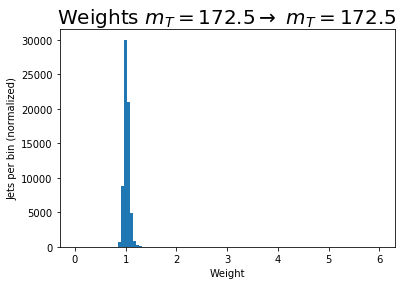

In [27]:
clip_val = 6
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_0, fontsize = 20)
plt.show()

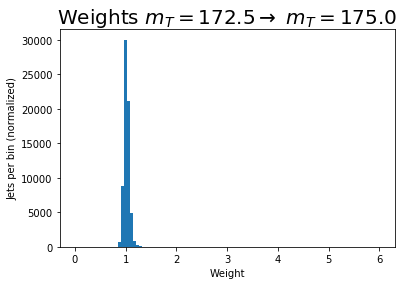

In [28]:
clip_val = 6
bins = np.linspace(0, clip_val, 101)
plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
plt.xlabel("Weight")
plt.ylabel('Jets per bin (normalized)')
plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_1, fontsize = 20)
plt.show()

### Validating Reweighting

In [29]:
test_obs_0 = np.load(data_dir + 'part_172_5_6j_obs.npy')
test_obs_1 = np.load(data_dir + 'part_175_0_6j_obs.npy')

In [30]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

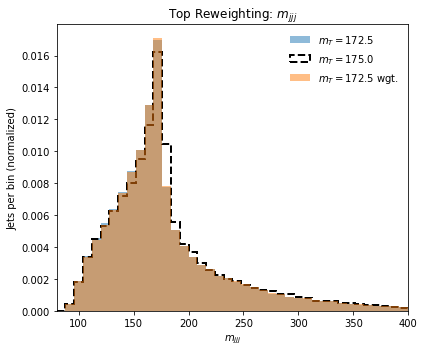

In [31]:
plt.figure(figsize=(6,5))
plt.title("Top Reweighting: $m_{jjj}$")
bins = np.linspace(80,400,41)
hist0 = plt.hist(test_obs_0[:,0], bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(test_obs_1[:,0], bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(test_obs_0[:,0], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

plt.xlabel('$m_{jjj}$')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([80,400])
make_legend()
#plt.savefig("Top Reweighting: m_{jjj} only.png")
plt.show()

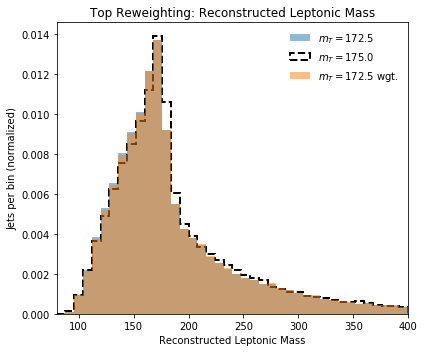

In [32]:
plt.figure(figsize=(6,5))
plt.title("Top Reweighting: Reconstructed Leptonic Mass")
bins = np.linspace(80,400,41)
hist0 = plt.hist(test_obs_0[:,1], bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(test_obs_1[:,1], bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(test_obs_0[:,1], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

plt.xlabel('Reconstructed Leptonic Mass')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([80,400])
make_legend()
#plt.savefig("Top Reweighting: m_{jjj} only.png")
plt.show()

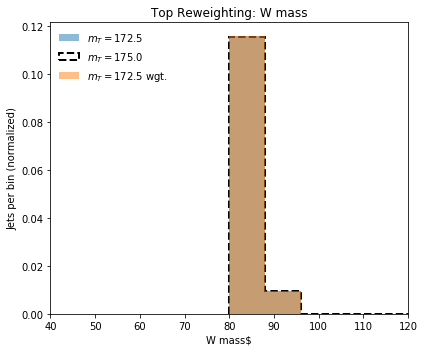

In [33]:
plt.figure(figsize=(6,5))
plt.title("Top Reweighting: W mass")
bins = np.linspace(80,400,41)
hist0 = plt.hist(test_obs_0[:,2], bins = bins, label = label_0, **plot_style_1)
hist1 = plt.hist(test_obs_1[:,2], bins = bins, label = label_1, **plot_style_0)
hist2 = plt.hist(test_obs_0[:,2], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

plt.xlabel('W mass$')
plt.ylabel('Jets per bin (normalized)')
plt.xlim([40,120])
make_legend()
#plt.savefig("Top Reweighting: m_{jjj} only.png")
plt.show()

Iteration:  0


Network Architecture Parameters:
Five hidden layers with 50 neurons each
max(weights_0) 1.316919
max(1/weights_0) 1.1546352
max(weights_1) 1.3168716
max(1/weights_1) 1.1544725


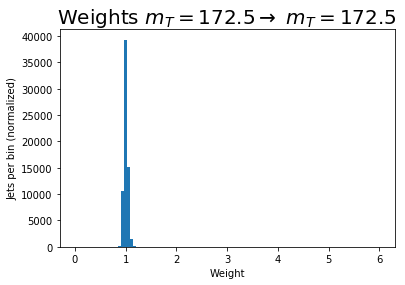

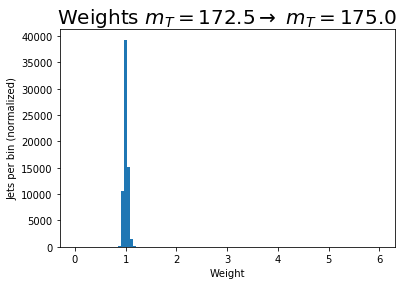

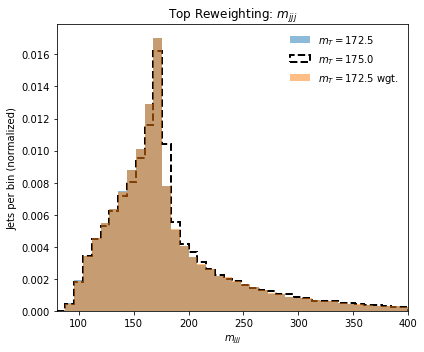

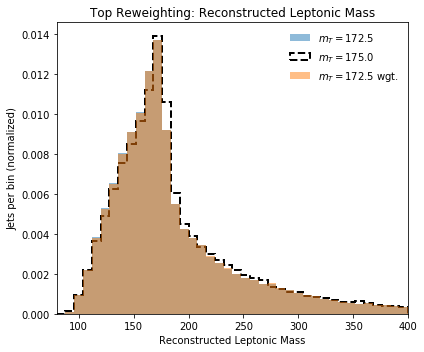

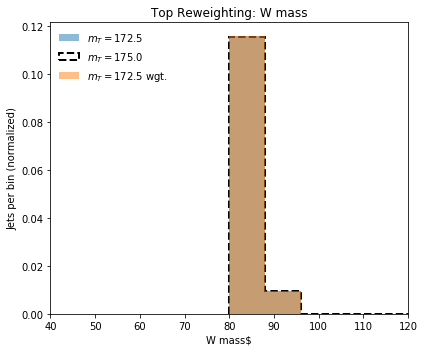

Iteration:  1
Network Architecture Parameters:
Five hidden layers with 50 neurons each
max(weights_0) 1.2143016
max(1/weights_0) 1.2572664
max(weights_1) 1.2143179
max(1/weights_1) 1.2572945


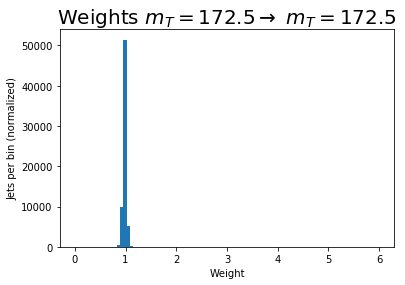

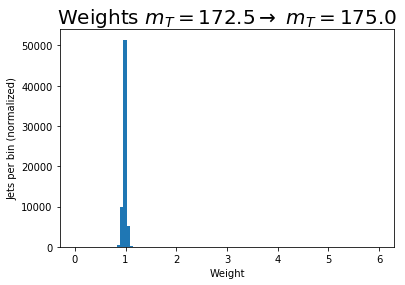

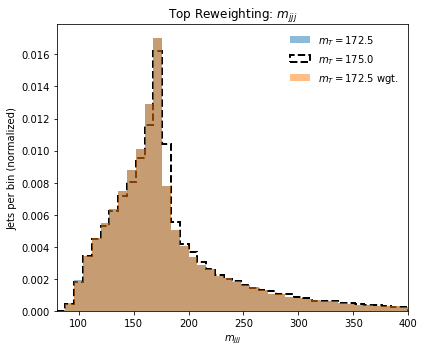

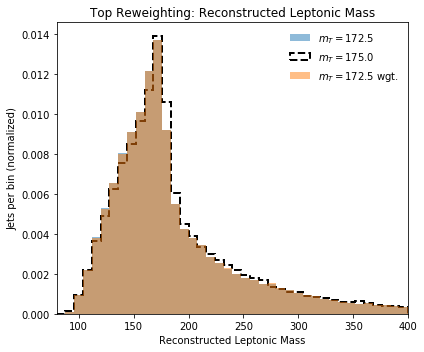

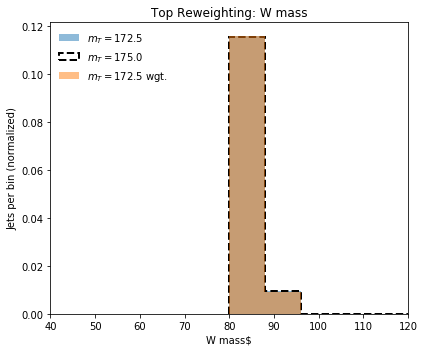

Iteration:  2
Network Architecture Parameters:
Five hidden layers with 50 neurons each
max(weights_0) 1.5481658
max(1/weights_0) 1.2125899
max(weights_1) 1.5482184
max(1/weights_1) 1.2125452


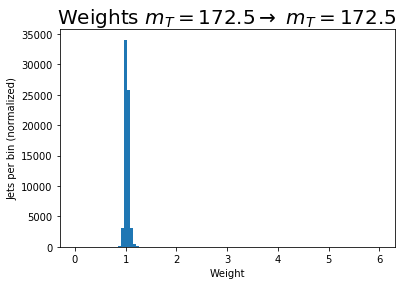

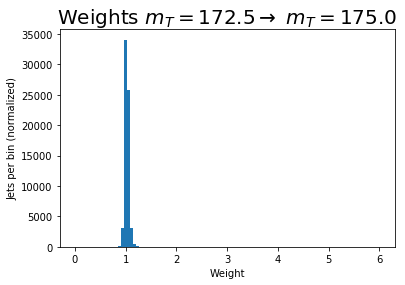

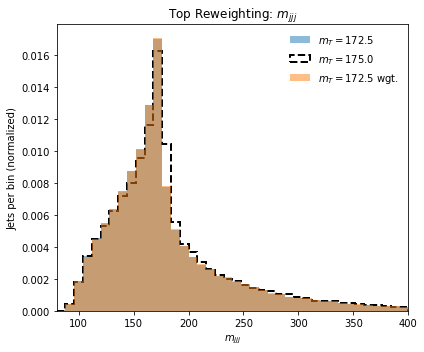

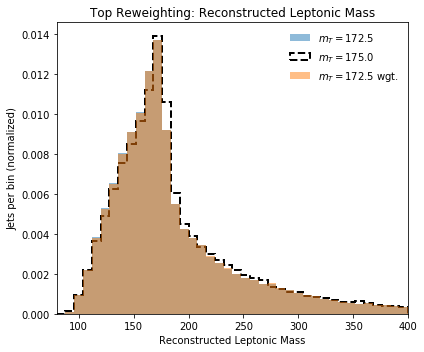

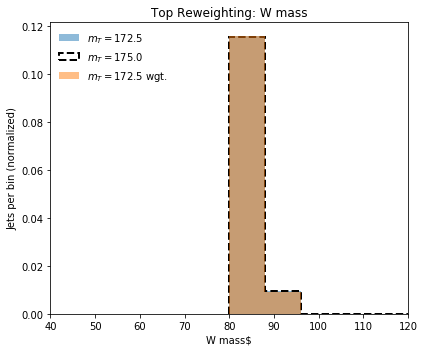

Iteration:  3
Network Architecture Parameters:
Five hidden layers with 50 neurons each
max(weights_0) 1.5266534
max(1/weights_0) 1.2808471
max(weights_1) 1.5267172
max(1/weights_1) 1.2807977


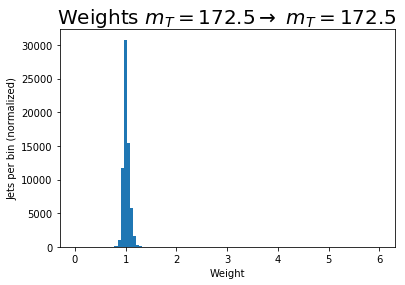

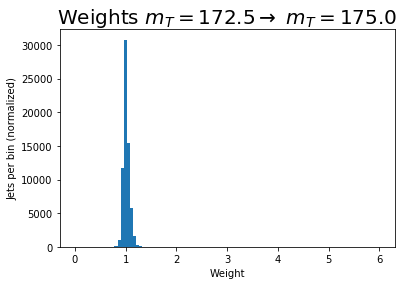

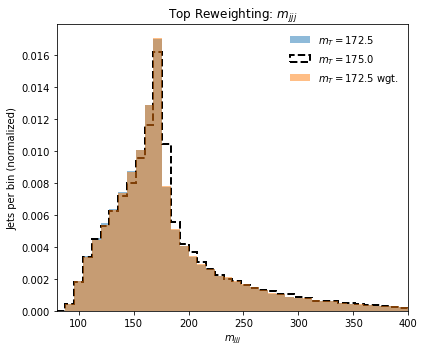

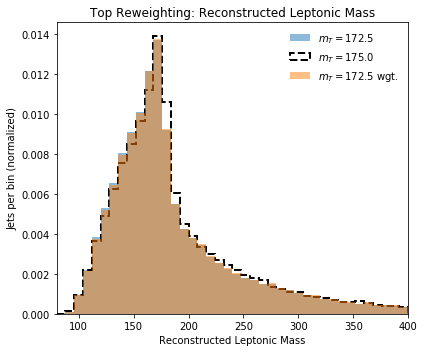

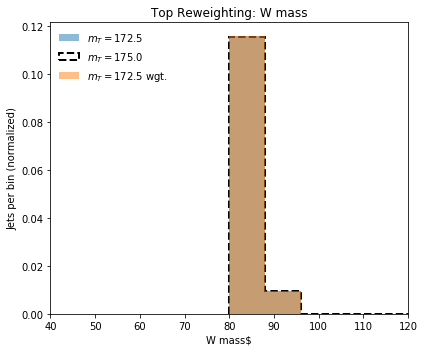

Iteration:  4
Network Architecture Parameters:
Five hidden layers with 50 neurons each
max(weights_0) 1.3255095
max(1/weights_0) 1.2463025
max(weights_1) 1.3253874
max(1/weights_1) 1.2463689


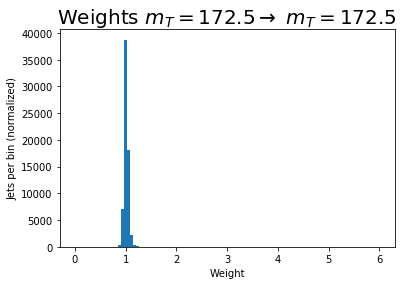

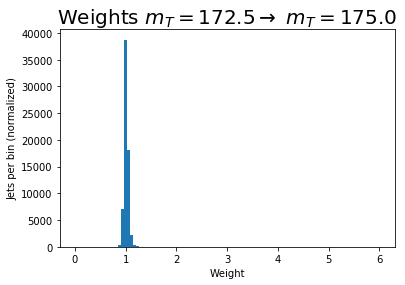

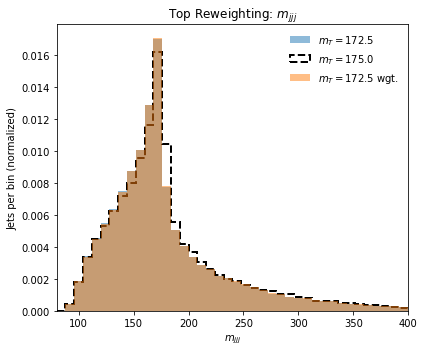

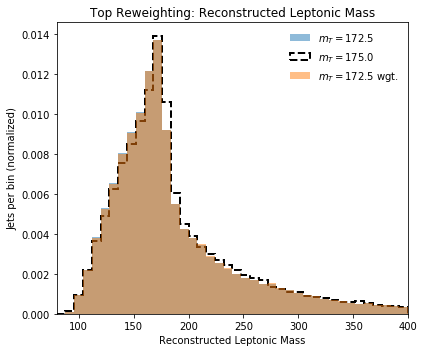

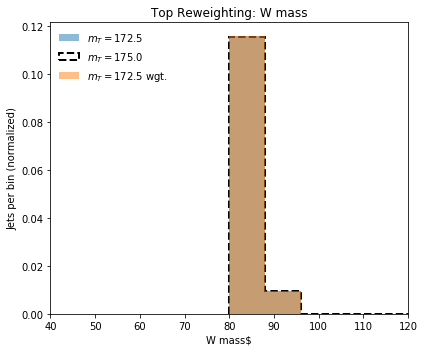

Iteration:  5
Network Architecture Parameters:
Three hidden layers with 50 neurons each
max(weights_0) 1.4721327
max(1/weights_0) 1.2926538
max(weights_1) 1.4722022
max(1/weights_1) 1.2926189


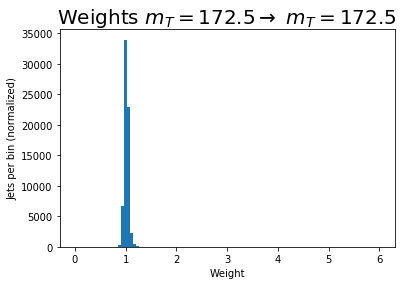

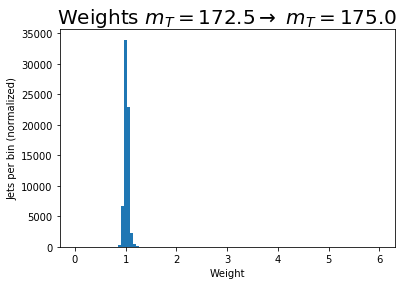

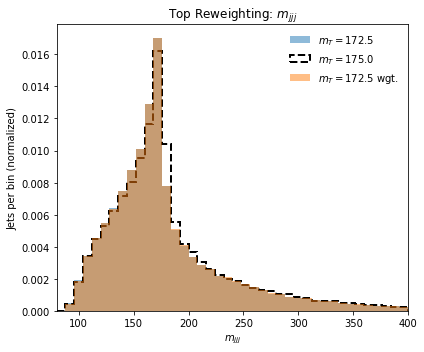

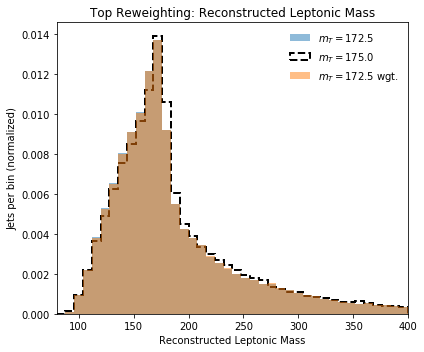

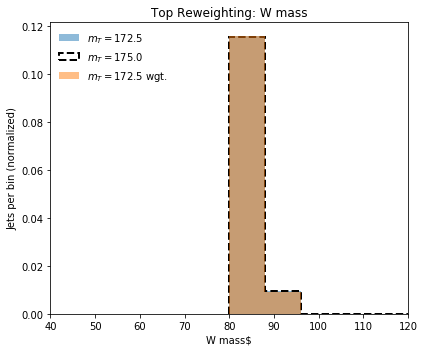

Iteration:  6
Network Architecture Parameters:
Three hidden layers with 50 neurons each
max(weights_0) 1.743221
max(1/weights_0) 1.354634
max(weights_1) 1.7429385
max(1/weights_1) 1.354654


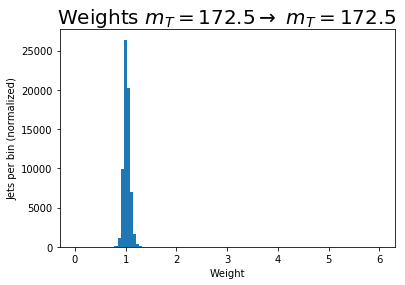

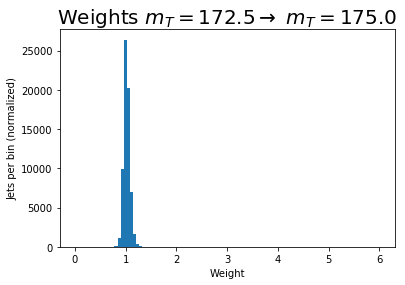

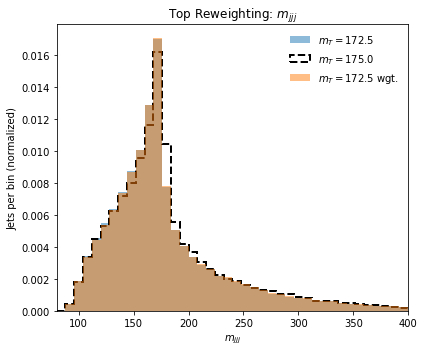

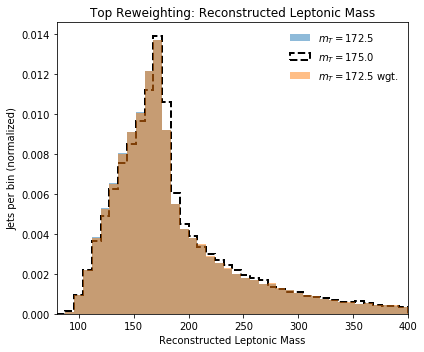

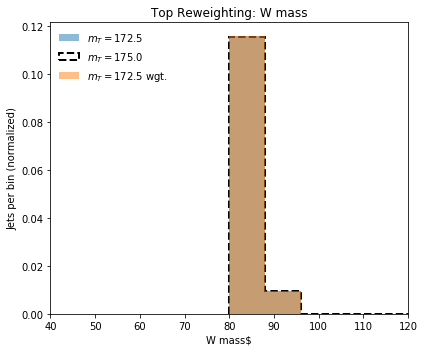

Iteration:  7
Network Architecture Parameters:
Three hidden layers with 50 neurons each
max(weights_0) 1.6535047
max(1/weights_0) 1.317225
max(weights_1) 1.6533216
max(1/weights_1) 1.3169311


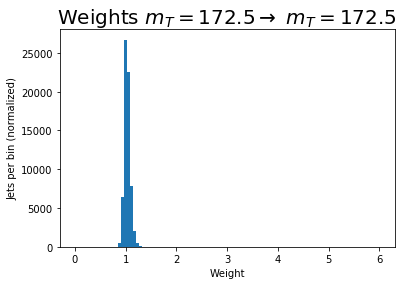

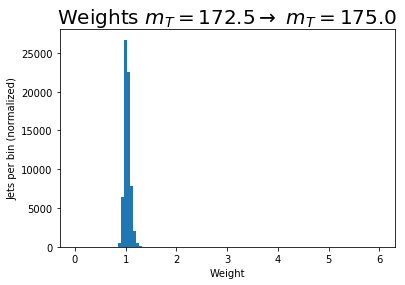

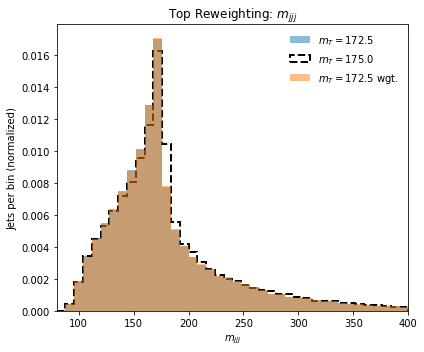

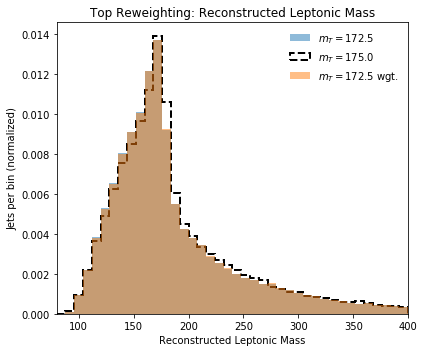

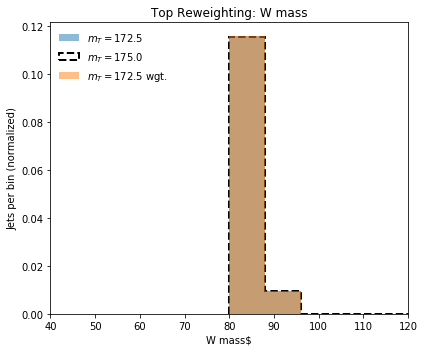

Iteration:  8
Network Architecture Parameters:
Three hidden layers with 50 neurons each
max(weights_0) 1.4252936
max(1/weights_0) 1.6909496
max(weights_1) 1.4252596
max(1/weights_1) 1.6905625


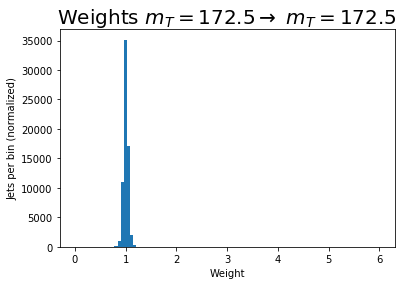

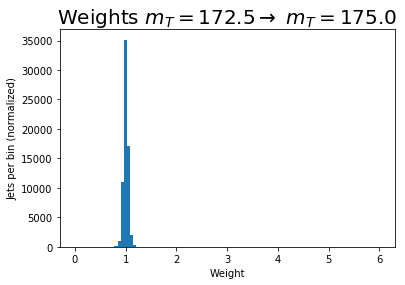

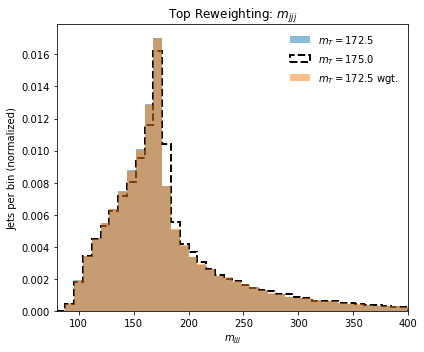

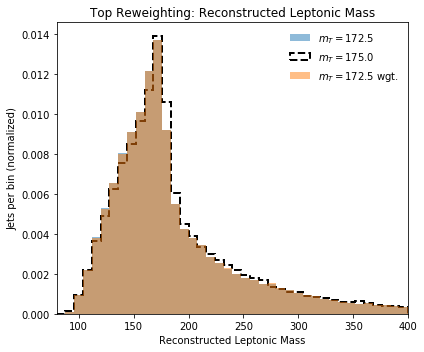

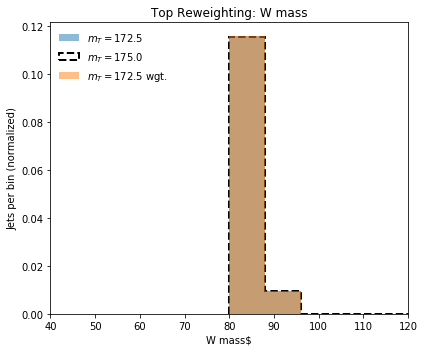

Iteration:  9
Network Architecture Parameters:
Three hidden layers with 50 neurons each
max(weights_0) 1.4094495
max(1/weights_0) 1.2907276
max(weights_1) 1.4094907
max(1/weights_1) 1.2905897


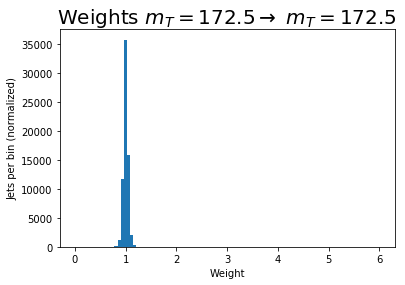

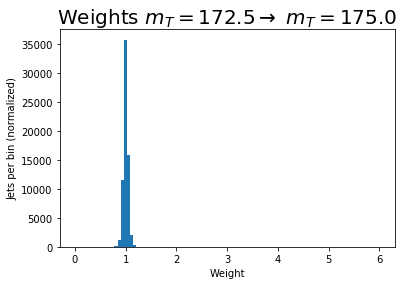

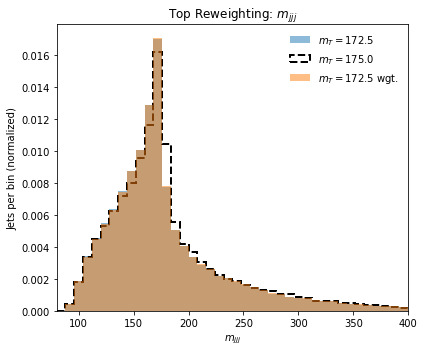

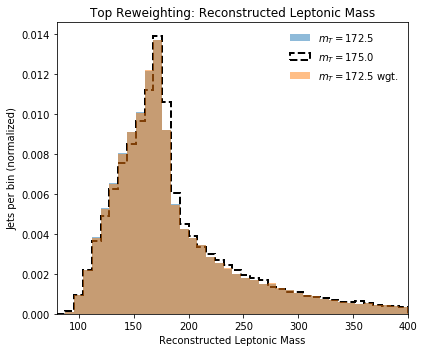

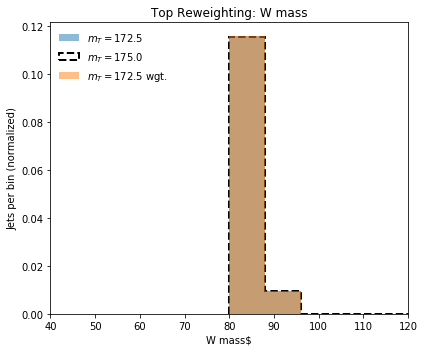

Iteration:  10
Network Architecture Parameters:
Two hidden layers with 100 neurons each
max(weights_0) 1.5646853
max(1/weights_0) 1.4440866
max(weights_1) 1.5648859
max(1/weights_1) 1.4441286


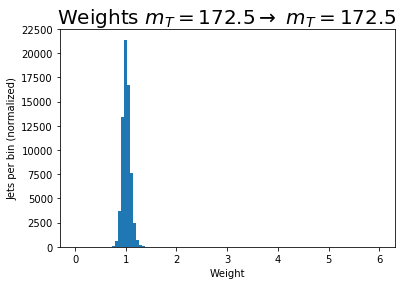

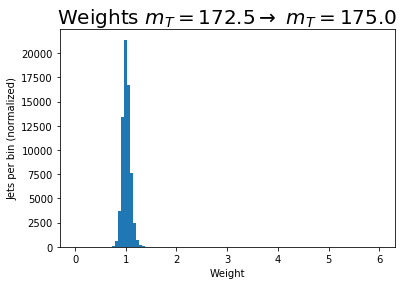

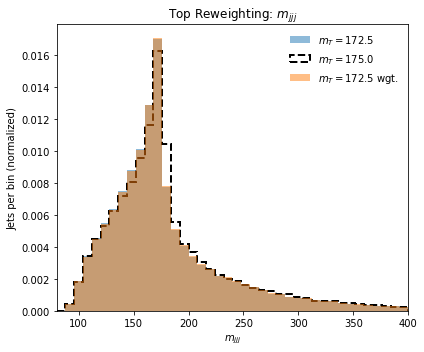

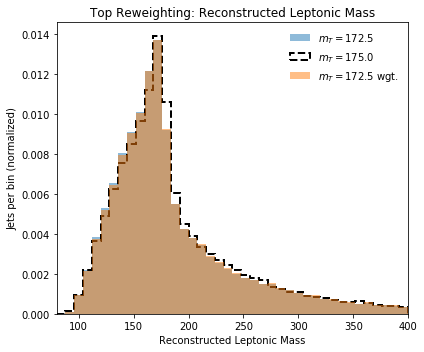

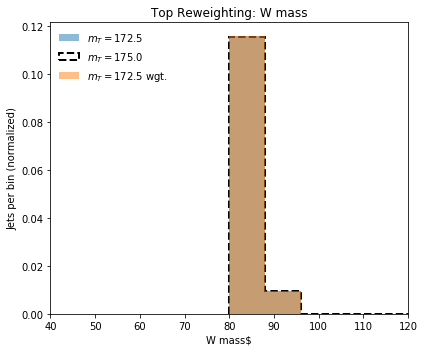

Iteration:  11
Network Architecture Parameters:
Two hidden layers with 100 neurons each
max(weights_0) 1.5768934
max(1/weights_0) 1.5677323
max(weights_1) 1.5767334
max(1/weights_1) 1.5674776


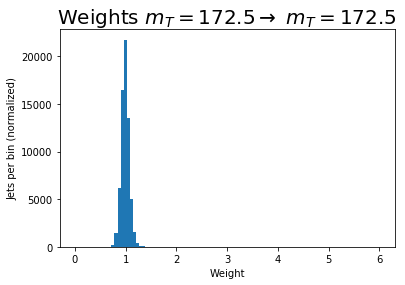

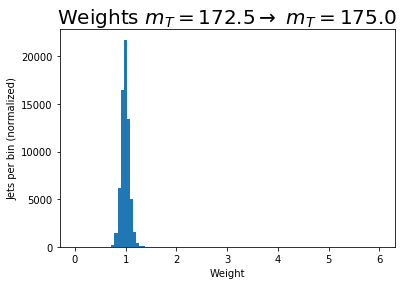

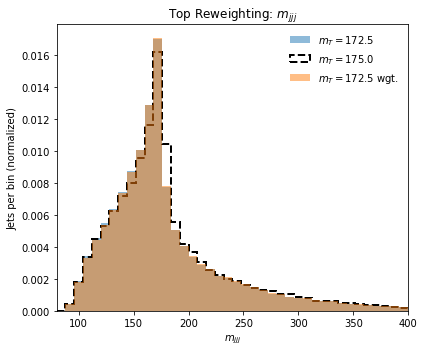

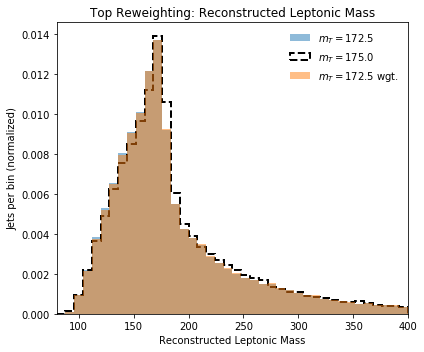

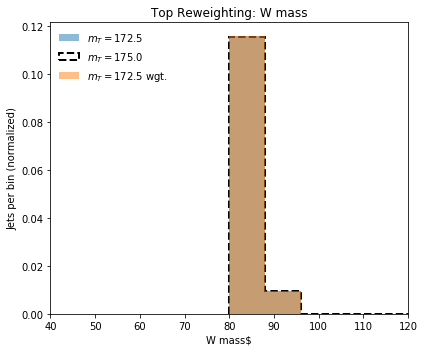

Iteration:  12
Network Architecture Parameters:
Two hidden layers with 100 neurons each
max(weights_0) 1.509256
max(1/weights_0) 1.4386709
max(weights_1) 1.5092316
max(1/weights_1) 1.4386452


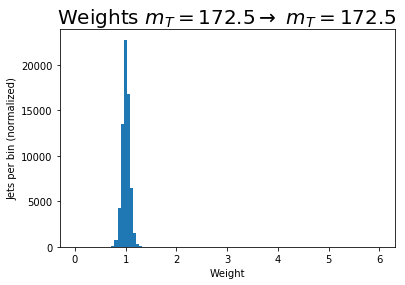

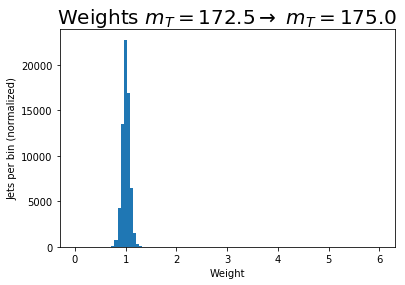

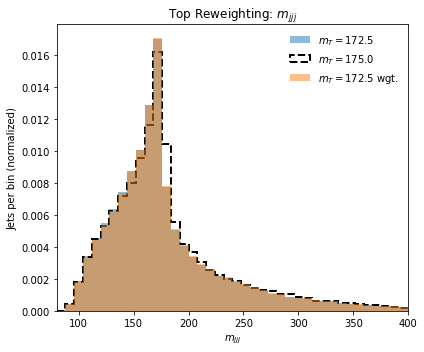

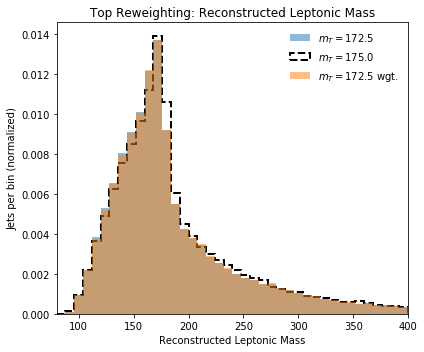

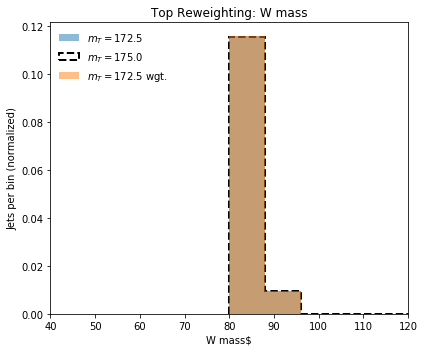

Iteration:  13
Network Architecture Parameters:
Two hidden layers with 100 neurons each
max(weights_0) 1.5218183
max(1/weights_0) 1.4820435
max(weights_1) 1.5218277
max(1/weights_1) 1.4818888


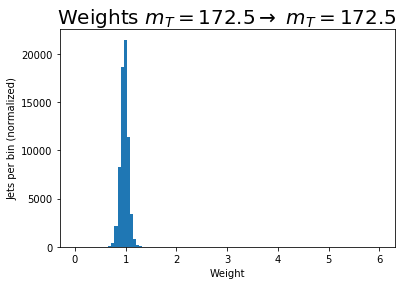

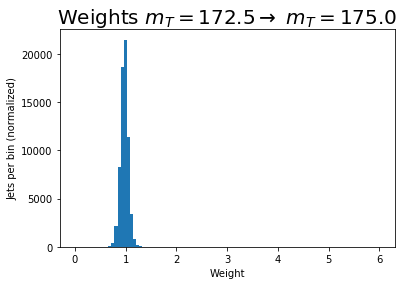

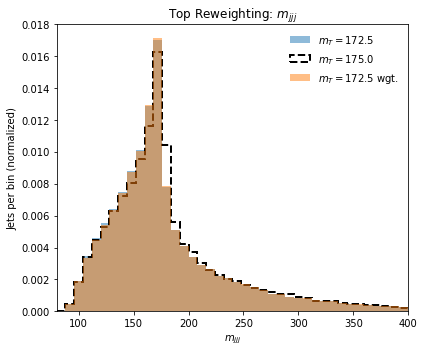

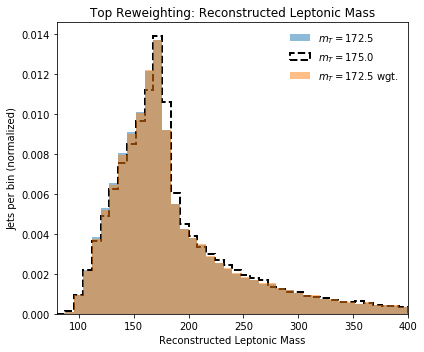

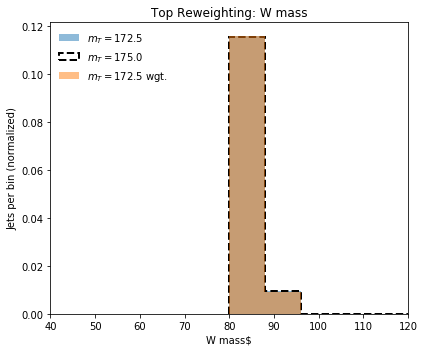

Iteration:  14
Network Architecture Parameters:
Two hidden layers with 100 neurons each
max(weights_0) 1.5193999
max(1/weights_0) 1.719093
max(weights_1) 1.5192972
max(1/weights_1) 1.7189333


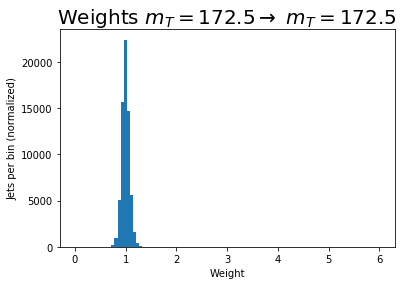

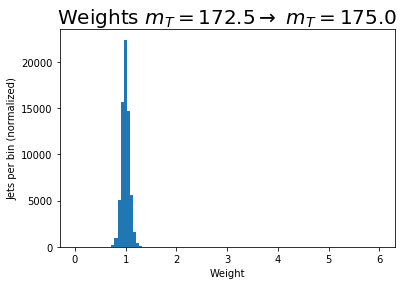

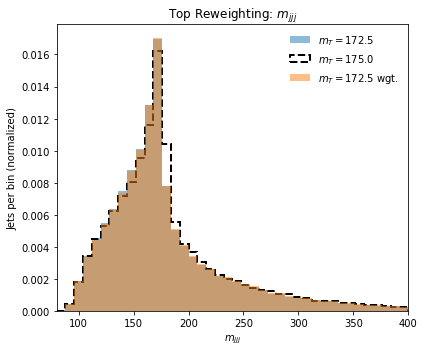

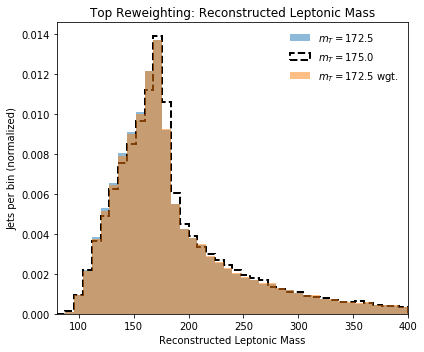

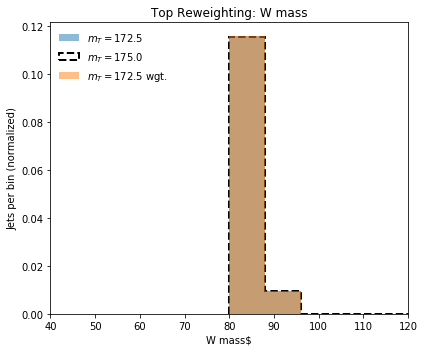

In [34]:
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0, 
                                              patience=20, 
                                              verbose=0, 
                                              restore_best_weights=True)

iterations = 15
for i in range(iterations):
    print("Iteration: ", i)

    K.clear_session()
    # Build Model
    inputs = Input((31, ))
    # network architecture parameters
    print("Network Architecture Parameters:")
    if i >= 10:
        print("Two hidden layers with 100 neurons each")
        hidden_layer_1 = Dense(100, activation='relu')(inputs)
        hidden_layer_f = Dense(100, activation='relu')(hidden_layer_1)
    elif i >= 5: 
        print("Three hidden layers with 50 neurons each")
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_f = Dense(50, activation='relu')(hidden_layer_2)
    else:
        print("Five hidden layers with 50 neurons each")
        hidden_layer_1 = Dense(50, activation='relu')(inputs)
        hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
        hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
        hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
        hidden_layer_f = Dense(50, activation='relu')(hidden_layer_4)

    outputs = Dense(2, activation='softmax')(hidden_layer_f)

    dctr = Model(inputs=inputs, outputs=outputs)
    dctr.compile(loss='categorical_crossentropy',
                       optimizer='Adam',
                       metrics=['accuracy'])
    history = dctr.fit(X_train,
                       Y_train,
                       epochs=100,
                       batch_size=1000,
                       validation_data=(X_val, Y_val),
                       verbose=0,
                       callbacks=[EarlyStopping])

    weights_0 = reweight(events = X0_test, param =172.5)

    weights_1 = reweight(events = X0_test, param =175.0)
    
    print('max(weights_0)', max(weights_0))
    print('max(1/weights_0)', max(1/weights_0))
    print('max(weights_1)', max(weights_1))
    print('max(1/weights_1)', max(1/weights_1))
    
    clip_val = 6
    bins = np.linspace(0, clip_val, 101)
    plt.hist(np.clip(weights_0, 0, clip_val), bins = bins)
    plt.xlabel("Weight")
    plt.ylabel('Jets per bin (normalized)')
    plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_0, fontsize = 20)
    plt.show()
    
    clip_val = 6
    bins = np.linspace(0, clip_val, 101)
    plt.hist(np.clip(weights_1, 0, clip_val), bins = bins)
    plt.xlabel("Weight")
    plt.ylabel('Jets per bin (normalized)')
    plt.title("Weights " + label_0 + r'$\rightarrow$ ' + label_1, fontsize = 20)
    plt.show()
    
    plt.figure(figsize=(6,5))
    plt.title("Top Reweighting: $m_{jjj}$")
    bins = np.linspace(80,400,41)
    hist0 = plt.hist(test_obs_0[:,0], bins = bins, label = label_0, **plot_style_1)
    hist1 = plt.hist(test_obs_1[:,0], bins = bins, label = label_1, **plot_style_0)
    hist2 = plt.hist(test_obs_0[:,0], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

    plt.xlabel('$m_{jjj}$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80,400])
    make_legend()
    #plt.savefig("Top Reweighting: m_{jjj} only.png")
    plt.show()
    
    plt.figure(figsize=(6,5))
    plt.title("Top Reweighting: Reconstructed Leptonic Mass")
    bins = np.linspace(80,400,41)
    hist0 = plt.hist(test_obs_0[:,1], bins = bins, label = label_0, **plot_style_1)
    hist1 = plt.hist(test_obs_1[:,1], bins = bins, label = label_1, **plot_style_0)
    hist2 = plt.hist(test_obs_0[:,1], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

    plt.xlabel('Reconstructed Leptonic Mass')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([80,400])
    make_legend()
    #plt.savefig("Top Reweighting: m_{jjj} only.png")
    plt.show()
    
    plt.figure(figsize=(6,5))
    plt.title("Top Reweighting: W mass")
    bins = np.linspace(80,400,41)
    hist0 = plt.hist(test_obs_0[:,2], bins = bins, label = label_0, **plot_style_1)
    hist1 = plt.hist(test_obs_1[:,2], bins = bins, label = label_1, **plot_style_0)
    hist2 = plt.hist(test_obs_0[:,2], bins = bins, label = label_0 + ' wgt.', weights=weights_1, **plot_style_1)

    plt.xlabel('W mass$')
    plt.ylabel('Jets per bin (normalized)')
    plt.xlim([40,120])
    make_legend()
    #plt.savefig("Top Reweighting: m_{jjj} only.png")
    plt.show() 